# imports

In [1]:
import cv2                                      # for image operations
import matplotlib.pyplot as plt                 # for visualisation
import numpy as np                              # for numerical operations
from google.colab.patches import cv2_imshow     # for displaying images on colab
from tqdm import tqdm
import random
import os
import IPython.display as Disp
from ipywidgets import widgets

# helper

In [2]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

# Get the images

In [3]:
import gdown

images = {
    "https://drive.google.com/file/d/12YEWbACYV8kbf7UN4-83raegh8T_b5PK/view?usp=sharing": "im0.png",
    "https://drive.google.com/file/d/1yUX_i88d8UFNFQza3l_RKbV1hu1haN3Z/view?usp=sharing": "im1.png"
    }

for url, file_name in images.items():
    gdown.download(url, file_name, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=12YEWbACYV8kbf7UN4-83raegh8T_b5PK
To: /content/im0.png
100%|██████████| 7.11M/7.11M [00:00<00:00, 79.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yUX_i88d8UFNFQza3l_RKbV1hu1haN3Z
To: /content/im1.png
100%|██████████| 7.07M/7.07M [00:00<00:00, 26.6MB/s]


# Stereo Vision

In this lab, we will be using an image from [Stereo Images Dataset](https://vision.middlebury.edu/stereo/data/scenes2014/). You can dive into the dataset and check out other images!

(2964, 2000)


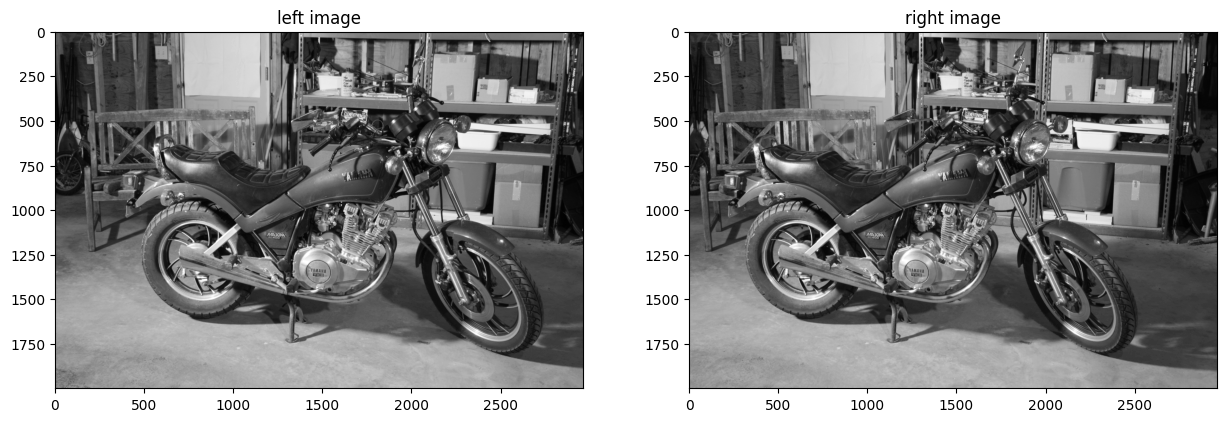

In [4]:
img0 = cv2.imread(f"im0.png", 0)
img1 = cv2.imread(f"im1.png", 0)

image_size = (img0.shape[1], img0.shape[0])
print(image_size)

plot_side_by_side(img0, img1, "left image", "right image")

`cam0,1`:        camera matrices for the rectified views, in the form:
$$
A =
\begin{bmatrix}
f & 0 & cx \\
0 & f & cy \\
0 & 0 & 1  \\
\end{bmatrix}
$$
>where;
>
>    `f`:           focal length
>
>    `cx, cy`:      principal point  (note that cx differs between view 0 and 1)

`baseline`:      camera baseline in mm


In [5]:
cam0 = np.array([
    [3979.911, 0, 1244.772],
    [0, 3979.911, 1019.507],
    [0, 0, 1]
], np.float32)

cam1 = np.array([
    [3979.911, 0, 1369.115],
    [0, 3979.911, 1019.507],
    [0, 0, 1]
], np.float32)

baseline = 193.001

focal_length = 3979.911

## 1. Detect and match features using SIFT between the images.

```
sift = cv2.SIFT_create()
```
> Used to create an instance of the Scale-Invariant Feature Transform (SIFT) algorithm.
>
> Returns an instance of the SIFT algorithm, which can be used to detect keypoints and compute descriptors in an image.



```
keypoints, descriptors = sift.detectAndCompute(image, mask)
```

> Used to detect keypoints and compute their descriptors in an image using a specified feature detector and descriptor extractor.
>
> `image:` The input image on which keypoints will be detected and descriptors will be computed.
>
> `mask:` An optional input mask specifying the region where keypoints need to be detected. It is a binary image of the same size as the input image, where pixels with non-zero values indicate the region of interest.

```
bf = cv2.BFMatcher(normType, crossCheck)
```

> Used to create an instance of a Brute-Force Matcher.
>
> Returns an instance of the Brute-Force Matcher.
>
> `normType:` An optional parameter that specifies the distance measurement to be used. It should be one of cv2.NORM_L1, cv2.NORM_L2, cv2.NORM_HAMMING, or cv2.NORM_HAMMING2.
>
> `crossCheck:` An optional boolean parameter. If True, the BFMatcher will only return consistent pairs. For normType=cv2.NORM_L1 or cv2.NORM_L2, the method knnMatch() will return the same results as match(). For normType=cv2.NORM_HAMMING or

```
matches = bf.knnMatch(des1, des2, k=2)
```
> Used to find k best matches between two sets of descriptors using the Brute-Force Matcher.
>
> Returns a list of k best matches. Each match is represented as a list of DMatch objects.
>
> `des1`: Descriptors from the first set.
>
> `des2`: Descriptors from the second set.
>
> `k`: Number of nearest neighbors to return. Default is k=2.



In [6]:
# Find keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img0, None)  # Detect keypoints and compute descriptors for the first image
kp2, des2 = sift.detectAndCompute(img1, None)  # Detect keypoints and compute descriptors for the second image

# Match keypoints using a Brute-Force Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)  # Match descriptors of keypoints between the two images

# Apply ratio test to select good matches
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Get corresponding points from the good matches
ptsLeft = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)   # Keypoints in the first image
ptsRight = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)  # Corresponding keypoints in the second image


## 2. Estimate the fundamental matrix using RANSAC between corresponding keypoints.

```
F, mask = cv2.findFundamentalMat(points1, points2, method, ransacReprojThreshold, confidence)
```
>  Used to compute the fundamental matrix from corresponding points in two images.
>
> Returns `F` the fundamental matrix and
`mask` a mask indicating inliers and outliers.
>> `Inliers`: The points that are likely to lie on the same epipolar line in both images.
>>
>>`Outliers`: Outliers are typically caused by errors in feature matching, occlusions, or mismatches between the images.
>
>`points1`: Array of points from the first image.
>
>`points2`: Array of points from the second image.
>
>`method`: Method used to compute the fundamental matrix. It can be one of cv2.FM_7POINT, cv2.FM_8POINT, or cv2.FM_RANSAC.
>
>`ransacReprojThreshold`: Reprojection threshold to determine inliers when method=cv2.FM_RANSAC. Default is 3.0.
>
>`confidence`: Confidence level, between 0 and 1, for the RANSAC algorithm. Default is 0.99.


In [7]:
F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, cv2.FM_RANSAC)

## 3. Filter the matched points using the mask obtained from RANSAC and subsample the remaining points.

> `Filtering outliers:` The mask obtained from RANSAC (Random Sample Consensus) indicates which points are inliers and outliers with respect to the estimated fundamental matrix. Filtering out the outliers ensures that only the reliable matches are used for further processing.
>
> `Subsampling:` Subsampling reduces the number of points to be processed, which can significantly speed up subsequent computations without significantly affecting the accuracy of the results.

In [8]:
# Filter matched points using the mask obtained from RANSAC
ptsLeft = ptsLeft[mask.ravel() == 1]  # Filtered keypoints in the left image
ptsRight = ptsRight[mask.ravel() == 1]  # Filtered keypoints in the right image

# Subsample the remaining points by selecting every step-th keypoint
step = 10
ptsLeft = ptsLeft[::step, :]  # Subsampled keypoints in the left image
ptsRight = ptsRight[::step, :]  # Subsampled keypoints in the right image

## 4. Compute epipolar lines and draw them on the images.

P.S - Since there will be lots of lines, it would be enough the visualize first 30.

```
lines = cv2.computeCorrespondEpilines(points, whichImage, F)
```
> Used to compute the epipolar lines corresponding to a set of points in one image.
>
> Returns array of computed epipolar lines.
>
> `points`: Array of points in one image for which the epipolar lines are to be computed.
>
> `whichImage`: Index of the image (1 or 2) that contains the corresponding points.
>
> `F`: The fundamental matrix.


In [9]:
def drawLines(img, lines, pts):
    # Get image dimensions
    h, w = img.shape

    # Convert the image to color
    img2vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw lines and points
    for r, pt in zip(lines[:30], pts[:30]):
        # Extract coordinates of keypoints
        pt1, pt2 = map(int, pt[0])

        # Generate a random color for visualization
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Calculate coordinates of two points on the epipolar line
        x0, y0 = map(int, [0, -r[2]/r[1]]) # Intersection point with the left edge of the image
        x1, y1 = map(int, [w, -(r[2]+r[0]*w)/r[1]]) # Intersection point with the right edge of the image

        # Draw epipolar lines
        img2vis = cv2.line(img2vis, (x0, y0), (x1, y1), color, 5)

        # Draw keypoints
        img2vis = cv2.circle(img2vis, (pt1, pt2), 15, color, -1)

    return img2vis


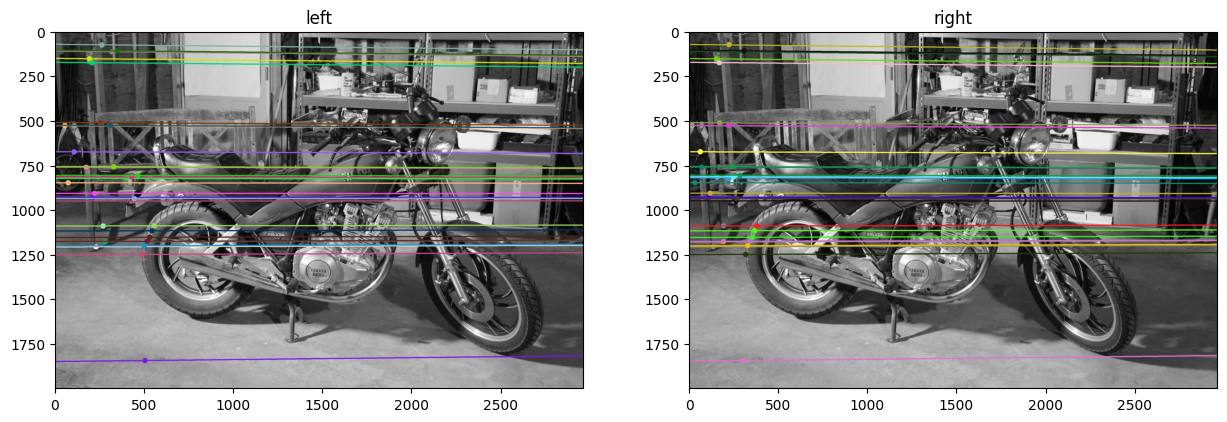

In [10]:
# Compute epipolar lines for the right image and draw them on the left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
# ptsRight.reshape(-1, 1, 2): Reshapes the ptsRight array into a 3D array with shape (number_of_points, 1, 2), as required by the function.

# .reshape(-1, 3): Reshapes the result into a 2D array with shape (number_of_points, 3).
# Each row of this array represents an epipolar line in homogeneous coordinates (a, b, c), where a*x + b*y + c = 0 is the equation of the epipolar line.

imgLeftLines = drawLines(img0, linesLeft, ptsLeft)

# Compute epipolar lines for the left image and draw them on the right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
imgRightLines = drawLines(img1, linesRight, ptsRight)

# Plot the images side by side
plot_side_by_side(imgLeftLines, imgRightLines, "left", "right")


## 5. Estimate the essential matrix using RANSAC.

> `Essential Matrix (E):`
In stereo vision, the essential matrix encapsulates the intrinsic properties of the camera (like focal length and principal point) and the relative pose between two views of a 3D scene.
It describes the epipolar geometry between two images taken by a camera undergoing a pure translation motion.
Mathematically, for two cameras with internal parameters $K_1$ and $K_2$, and rotation $𝑅$ and translation $t$ from camera 1 to camera 2.

```
E, mask = cv2.findEssentialMat(points1, points2, cameraMatrix, method, prob, threshold, mask)
```

> Used to compute the essential matrix from corresponding points in two images.
>
> Returns `E` the essential matrix, and
`mask` an output mask indicating inliers and outliers.
>
>`points1`: Array of points from the first image.
>
>`points2`: Array of points from the second image.
>
>`cameraMatrix`: Camera matrix $K$ containing the focal lengths and principal point.
>
>`method`: Method used to compute the essential matrix. It can be one of cv2.RANSAC or cv2.LMEDS.
>
>`prob`: Probability that the algorithm produces a useful result (used only for method=cv2.RANSAC). Default is 0.999.
>
>`threshold`: Threshold value for the RANSAC or LMedS methods. Default is 1.0.
>
>`mask`: Output mask indicating inliers and outliers. It is optional.


In [ ]:
E, _ = cv2.findEssentialMat(ptsLeft, ptsRight, cam0, method=cv2.RANSAC, prob=0.999, threshold=1.0)

In [ ]:
E

array([[-4.57818043e-05,  1.84102149e-02,  7.48163229e-03],
       [-1.42043032e-02,  3.10970808e-04, -7.06924526e-01],
       [-7.52260839e-03,  7.06826910e-01,  2.67411779e-04]])

## 6. Recover the relative camera pose from the essential matrix.

```
retval, R, t, mask = cv2.recoverPose(E, points1, points2, cameraMatrix, mask)
```

> Used to recover the relative pose between two calibrated cameras from the essential matrix and the corresponding points.
>
> Returns `retval` a boolean indicating whether the pose was successfully recovered or not, `R` the rotation matrix, `t` the translation vector, and
`mask` output mask indicating inliers and outliers.
>
>`E`: The essential matrix.
>
>`points1`: Array of points from the first image.
>
>`points2`: Array of points from the second image.
>
>`cameraMatrix`: Camera matrix 𝐾 containing the focal lengths and principal point.
>
>`mask`: Input/output mask indicating inliers and outliers. It is optional.

In [ ]:
_, R, t, _ = cv2.recoverPose(E, ptsLeft, ptsRight, cam0)

In [ ]:
R # rotation matrix

array([[ 9.99982269e-01,  6.68378917e-05,  5.95464879e-03],
       [-6.94668335e-05,  9.99999900e-01,  4.41288275e-04],
       [-5.95461870e-03, -4.41694101e-04,  9.99982174e-01]])

In [ ]:
t # translation vector

array([[-0.99960501],
       [-0.01056932],
       [ 0.02604065]])

## 7. Rectify the images to make camera pose's parallel and thus make epipolar lines as horizontal.

```
_, H1, H2 = cv2.stereoRectifyUncalibrated(ptsLeft, ptsRight, F, imageSize=image_size)

```

> Used to rectify images without knowing the internal camera parameters.
>
>Returns `retval` a boolean indicating whether the rectification was successful or not, `H1` the rectification transform for the left image, and `H2` the rectification transform for the right image.
>
>`ptsLeft`: Array of points from the left image.
>
>`ptsRight`: Array of points from the right image.
>
>`F`: The fundamental matrix.
>
>`imageSize`: Size of the images.

In [ ]:
# Rectify the images using stereo rectification
# H1 and H2 are the rectification transforms for the left and right images, respectively
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.float32(ptsLeft), np.float32(ptsRight), F, imgSize=image_size)

# Print rectification matrices
print("H1", H1, "\n")
print("H2", H2)

# Initialize arrays to store rectified feature points
rectified_ptsLeft = np.zeros((ptsLeft.shape), dtype=int)
rectified_ptsRight = np.zeros((ptsRight.shape), dtype=int)

# Rectify the feature points
for i in range(ptsLeft.shape[0]):
    source1 = np.array([ptsLeft[i][0][0], ptsLeft[i][0][1], 1])
    new_point1 = np.dot(H1, source1)
    new_point1[0] = int(new_point1[0] / new_point1[2])
    new_point1[1] = int(new_point1[1] / new_point1[2])
    new_point1 = np.delete(new_point1, 2)
    rectified_ptsLeft[i] = new_point1

    source2 = np.array([ptsRight[i][0][0], ptsRight[i][0][1], 1])
    new_point2 = np.dot(H2, source2)
    new_point2[0] = int(new_point2[0] / new_point2[2])
    new_point2[1] = int(new_point2[1] / new_point2[2])
    new_point2 = np.delete(new_point2, 2)
    rectified_ptsRight[i] = new_point2

# Rectify the images
img0_rectified = cv2.warpPerspective(img0, H1, image_size)
img1_rectified = cv2.warpPerspective(img1, H2, image_size)

H1 [[ 9.45256600e+01 -1.00499648e+01 -2.18379403e+03]
 [-1.10410743e+00  9.70447304e+01  1.65427416e+03]
 [-1.17014001e-03  7.95401673e-05  9.87311239e+01]] 

H2 [[ 9.82326033e-01 -4.02591442e-04  2.65954110e+01]
 [-1.15158624e-02  1.00000480e+00  1.70617045e+01]
 [-1.19256972e-05  4.88756634e-09  1.01766900e+00]]


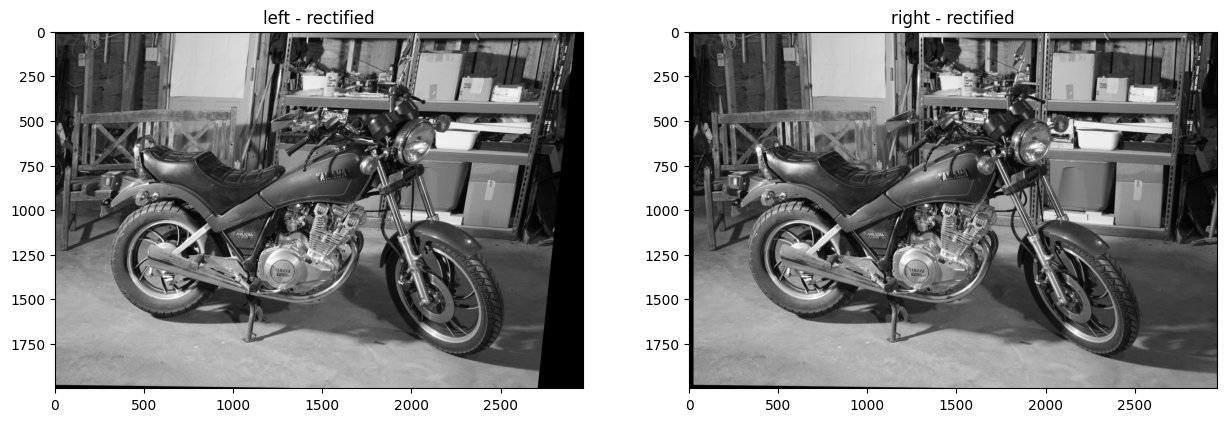

In [ ]:
plot_side_by_side(img0_rectified, img1_rectified, "left - rectified", "right - rectified")

## 8. Compute and draw epipolar lines on rectified images.

P.S. Find epipolar lines corresponding to points in right image and draw its lines on left image. And vice versa.

In [ ]:
# Compute epipolar lines for the rectified right image and draw them on the rectified left image
recLinesRight = cv2.computeCorrespondEpilines(rectified_ptsRight.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
recLeftImgLines = drawLines(img0_rectified, recLinesRight, rectified_ptsLeft)

# Compute epipolar lines for the rectified left image and draw them on the rectified right image
recLinesLeft = cv2.computeCorrespondEpilines(rectified_ptsLeft.reshape(-1, 1, 2), 1, F).reshape(-1, 3)
recRightImgLines = drawLines(img1_rectified, recLinesLeft, rectified_ptsRight)


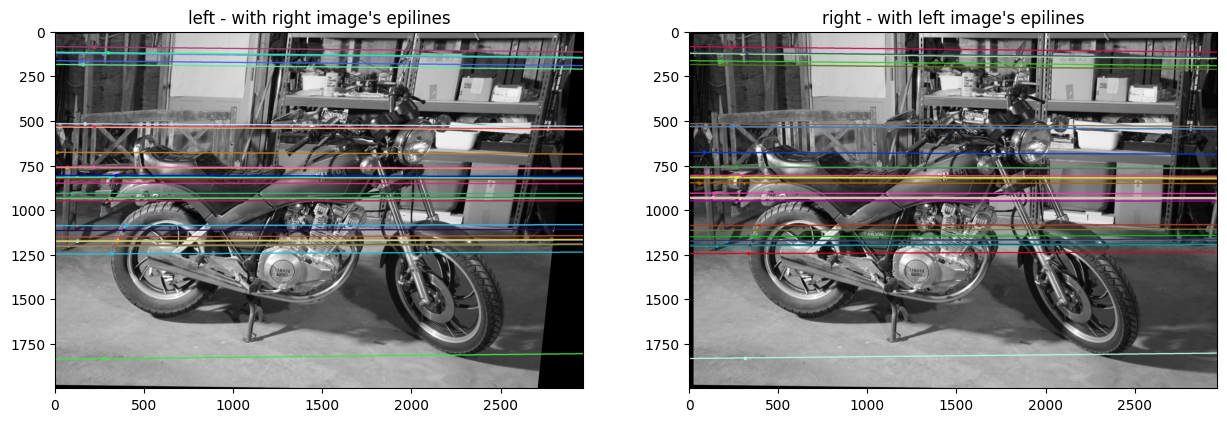

In [ ]:
plot_side_by_side(recLeftImgLines, recRightImgLines, "left - with right image's epilines", "right - with left image's epilines")

## 9. Compute the disparity map using Stereo Block Matching (BM).

```
stereo = cv2.StereoBM_create(numDisparities, blockSize)
```

> Used to create an instance of the Block Matching (BM) stereo correspondence algorithm.
>
> Returns an instance of the StereoBM algorithm, which can be used to compute disparity maps from rectified stereo images.
>
>`numDisparities`: The disparity search range. It should be divisible by 16. Typical values are between 16 and 256.
>
>`blockSize`: Size of the blocks compared for matching. It must be an odd number (e.g., 5, 7, 9, 11, ...).

```
disparity = stereo.compute(img1, img2)
```
> Used to compute the disparity map from rectified stereo image pairs using the StereoBM algorithm.
>
>Returns the computed disparity map.
>
>`img1`: The left rectified grayscale image.
>
>`img2`: The right rectified grayscale image.

In [ ]:
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
# The numDisparities parameter determines the number of disparities to be computed.
# Disparity represents the shift along the epipolar line that maximizes the similarity
# between the corresponding pixels in the two images.

# The blockSize parameter sets the size of the window used for matching. It represents
# the size of the block around each pixel that is used for matching.


disparity = stereo.compute(img0_rectified, img1_rectified)

## 10. Compute the depth map from the disparity map.

In [ ]:
# Initialize the depth map
depth_map = np.zeros(disparity.shape, dtype=np.float32)

# Compute depth map
depth_map[disparity > 0] = (focal_length * baseline) / disparity[disparity > 0]


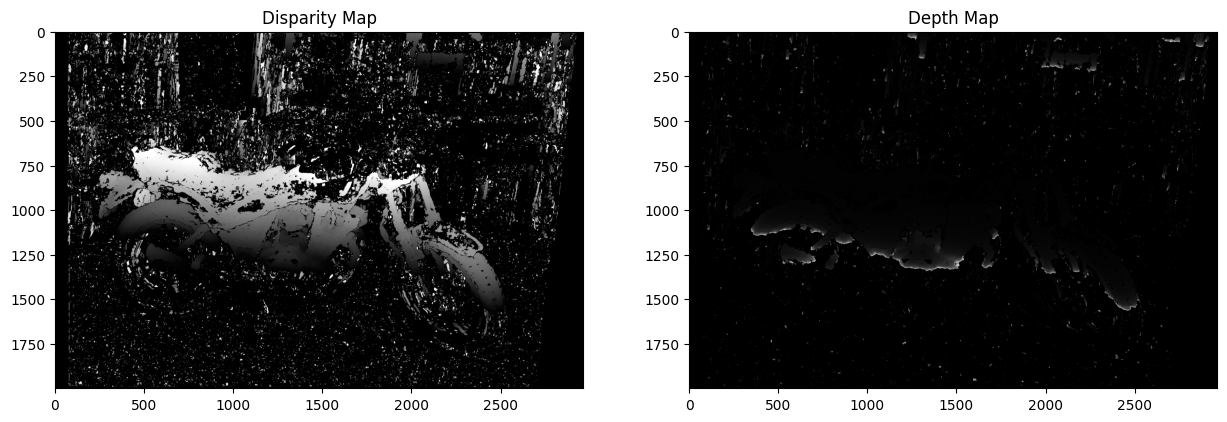

In [ ]:
plot_side_by_side(disparity, depth_map / 1000, "Disparity Map", "Depth Map")

# we divide the depth map by 1000 to convert it from millimeters to meters,
# assuming that the focal_length and baseline are given in millimeters